# Example of calculation of a stable geotherm

Copyright 2020 Marco A. Lopez-Sanchez

Mozilla Public License 2.0: https://www.mozilla.org/en-US/MPL/2.0/

> **Goal of the notebook**: Estimate and plot a steady-state thermal gradient for the continental lithosphere considering a two-layer model (crust vs lithospheric mantle) using the Turcotte and Schubert (1982) model.

In [1]:
# import the required Python scientific libraries
import numpy as np
import matplotlib.pyplot as plt

# set a custom figure style (optional, you can comment on this whole block)
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
mpl.rcParams['figure.facecolor'] = 'ffffff'
mpl.rcParams['axes.facecolor'] = 'ffffff'
mpl.rcParams['axes.edgecolor'] = 'ffffff'

TODO -> Flow laws

Let's make some assumptions first: 
- the geotherm is in **steady state** and thus temperature only vary as a function of depth $(z)$.
- Heat is transferred by conduction in the lithosphere.
- The temperature gradient with depth $(\frac{dT}{dz})$ depends on heat conduction plus the heat produced due to radioactive decay.
- Radioactive heat production in the crust and the mantle are independent of depth.

Taking this assumptions, Turcotte and Schubert (1982) proposed an analytical solution of the heat equation that have three terms

$T_z = T_{z0} + \frac{J_q}{K}(z - z_0) - \frac{A_0}{2K}(z - z_0)^2$

- $T_z$ is the temperature variation with depth $(\frac{dT}{dz})$ (a.k.a. the geotherm).
- The first term, $T_{z0}$, is the temperature on the surface of the Earth.
- The second term, $\frac{J_q}{K}(z - z_0)$ account for the heat conduction and includes the average heat flux ($J_q$), the coefficient of thermal conductivity ($K$), and the upper and lower depth limits $(z - z_0)$.
- The third term, $\frac{A_0}{2K}(z - z_0)^2$ accounts for the heat production and it includes a new parameter called the average heat productivity ($A_0$).

This equation allow us to estimate the temperature gradient from the surface temperature if we know the parameters $J_q$, $K$, and $A_0$. Now, let's convert this into a Python function named ``turcotte_schubert_model``:

In [2]:
def turcotte_schubert_model(z0, z, T0, Jq, A, K):
    """ Apply the equation (model) of Turcotte and Schubert (1982) (ts) to estimate
    a steady-state geotherm (i.e. the T at a given depth)

    Parameters (all positive scalars except z)
    ----------
    z0 : upper depth limit [km]
    z : lower depth limit [km] (scalar or array-like)
    T0 : temperature at the upper depth limit [K]
    Jq : average heat flux [mW m**-2]
    A : average heat productivity [microW m**-3]
    K : coefficient of thermal conductivity [W m**-1 K**-1]

    Assumptions
    -----------
    TODO

    Returns
    -------
    The temperature in K, a floating point number
    """
    
    # check for positive values
    if np.any([z0, T0, Jq, A, K]) < 0 and np.any(z) < 0:
        print('all parameters must be positive scalars')

    return T0 + ((Jq / K) * (z - z0)) - ((A / (2 * K)) * (z - z0)**2)

Now let set the boundary conditions for the model.

In [3]:
moho = 38.8 # Continental crust thickness [m], average from Hacker et al. (2015)
Lab = 81  # Lithosphere-asthenosphere boundary (Lab) [m], average beneath tectonically altered regions (Rychert and Shearer, 2009)
T_init = 7.5  # surface T at the KTB superdeep borehole

# Average heat parameters for the crust and the mantle
Jq_crust = 65  # Average heat flux [mW m**-2] from Jaupar and Mareschal (2007)
A_crust = 0.97  # Average rate of radiogenic heat production [microW m**-3] from Huang et al. (2013)
K_crust = 2.51  # Coefficient of thermal conductivity [W m**-1 K**-1] from Sclater et al. (1980)

Jq_mantle = 34  # from Sclater et al. (1980)
A_mantle = 0.01  # from Sclater et al. (1980)
K_mantle = 3.35  # in peridotite at room T (Sclater et al., 1980)

Now we need to generate an array with the depths...TODO

In [4]:
# generate a linear spaced array of depths every 10 m from 0 to the depth of the
# lithosphere-asthenosphere boundary (Lab)
depths = np.linspace(start=0, stop=Lab, num=8100)

In [5]:
T_crust = turcotte_schubert_model(0,
                                  depths[depths <= moho],
                                  T_init,
                                  Jq_crust,
                                  A_crust,
                                  K_crust)

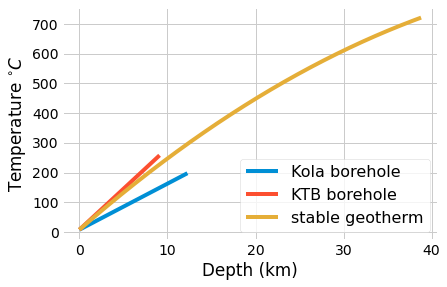

In [6]:
# plot depth vs temperature
fig1, ax = plt.subplots()

ax.plot([0, 12.262], [7.5, 197.6], label='Kola borehole')
ax.plot([0, 9.101], [7.5, 257.8], label='KTB borehole')
ax.plot(depths[depths <= moho], T_crust, label='stable geotherm')
ax.set(xlabel='Depth (km)', ylabel='Temperature $^{\circ}C$')
ax.legend(loc='lower right', fontsize=16)

# For plotting the T gradient of superdeep boreholes I used
# ax.plot([x0, x1], [y0, y1]) where:
# x0 : z0 [km]
# x1 : maximum depth of the borehole [km]
# y0 : T at the start of the borehole (surface)
# y1 : T at the maximum depth of the borehole (y0 + x1 * T gradient in [K/km])

Note that the estimated geotherm are whithin the T gradients found in the KTB (Emmermann and Lauterjung, 1997) and Kola superdeep (Smithson et al., 2000) boreholes, where gradients are of 27.5 and 15.5 K/km respectively. In this case, very close to the gradient measured in the KTB borehole. If we want to know how is the temperature at the base of the crust, we can use the array containing all the temperatures ``T_crust`` and extract the last value as follows

In [7]:
print('T at the Moho =', T_crust[-1])

T at the Moho = 721.3322733737868


Now, let's calculate the T gradient in the lithospheric mantle. For this we need to establish a new frame of reference that defines the boundary conditions at the top of the mantle, i.e. the depth and the temperature at the Moho.

In [8]:
# get the closest depth to the Moho
new_ref_frame = depths[depths <= moho][-1]

# Estimate the T gradient
T_mantle = turcotte_schubert_model(new_ref_frame,  # the depth of the Moho (i.e. where the mantle begins)
                                   depths[depths > moho],
                                   T_crust[-1],  # take the T at the Moho as T0
                                   Jq_mantle,
                                   A_mantle,
                                   K_mantle)

# Stack the two arrays in sequence horizontally 
T_lithosphere = np.hstack((T_crust, T_mantle))

[Text(0.5, 0, 'Temperature $^{\\circ}C$'), Text(0, 0.5, 'Depth (km)')]

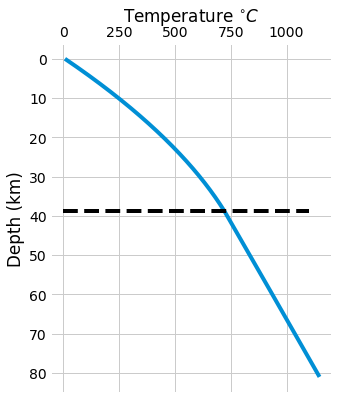

In [9]:
# plot the geotherm for the entire lithosphere
fig2, ax = plt.subplots(figsize=(4.5, 6))

# tweak the figure so that the depth is shown on the y-axis downwards
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

ax.plot(T_lithosphere, depths)
ax.plot([0, 1100], [moho, moho], color='black', linestyle='dashed')
ax.set(xlabel='Temperature $^{\circ}C$', ylabel='Depth (km)')

For reference, let's plot the $Al_2SiO_4$ stability field in the depth vs temperature space according to Holdoway data.

(50.0, -1.0)

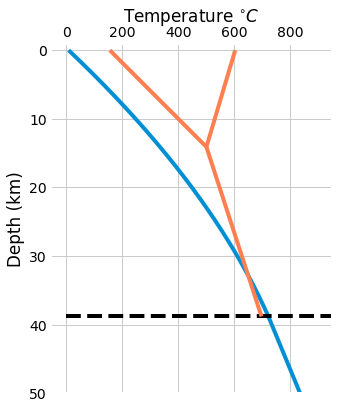

In [11]:
# set some data
ro_crust = 2750  # average rock density in the crust [kg/m**3]
g = 9.80665      # 
tp_T = 500       # triple point T in C degrees
tp_P = 380000    # triple point P in Pas
tp_depth = tp_P / (ro_crust * g)
Ky_And_T = 154.85    # at room P
And_Sill_T = 602.85  # at room P
Ky_Sill_T = 696.85   # at Moho P

fig3, ax = plt.subplots(figsize=(4.5, 6))

# tweak the figure so that the depth is shown on the y-axis downwards
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

ax.plot(T_lithosphere, depths)
ax.plot([0, 1100], [moho, moho], color='black', linestyle='dashed')
ax.set(xlabel='Temperature $^{\circ}C$', ylabel='Depth (km)')

# plot Al2SiO4 stability fields
ax.plot([Ky_And_T, tp_T], [0, tp_depth], color='coral')  # Ky-And line
ax.plot([tp_T, And_Sill_T], [tp_depth, 0], color='coral')  # And-Sill line
ax.plot([tp_T, Ky_Sill_T], [tp_depth, moho], color='coral')  # Ky-Sill line

# focus on the crust
ax.set_xlim(xmax=950)
ax.set_ylim(ymin=50, ymax=-1)

We observe that the calculated geotherm never enters the stability field of the Andalusite but the field of the sillimanite near the Moho discontinuity (at ~34 km of depth)